In [ ]:
# Import required modules. This may take a while.
from google.colab import files
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
import pandas
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [ ]:
# Files uploaded will be kept until the runtime is closed.
# Expand the floder icon on the left sidebar to see the files.
# Rerun this block to upload more files.
# Accepted format: .xlsx, .csv
uploaded = files.upload()

Saving test.xlsx to test.xlsx


In [ ]:
filename = 'test.xlsx' # Replace with file you want to analyze and rerun block.
if filename.endswith('.xlsx'):
    df = pandas.read_excel(filename)
elif filename.endswith('.csv'):
    df = pandas.read_csv(filename)
data = df.iloc[:, 1:]
# --- Testing GC only --- #
#data.iloc[:, 3] = data.iloc[:,0]*data.iloc[:,2]+data.iloc[:,1]*data.iloc[:,3]

# Scale data by normalization
scaler = StandardScaler()
scaler.fit(data)
data=scaler.transform(data)

#print(data)
labels = df.iloc[:, 0].to_numpy()
parser = lambda name : name.split('_')[0]
labels = np.array([parser(l) for l in labels])
# IMPORTANT: The colormap is hardcoded assuming there are only four unique labels: M0, M1, M2a, M2c.
# If there are additional or different labels, the cdict above need to be modified for visualization.
cdict = {
    'M0': 'red',
    'M1': 'blue',
    'M2a': 'green',
    'M2c': 'magenta'
}
print(labels)

['M0' 'M0' 'M0' 'M0' 'M0' 'M0' 'M0' 'M0' 'M0' 'M0' 'M0' 'M0' 'M1' 'M1'
 'M1' 'M1' 'M1' 'M1' 'M1' 'M1' 'M1' 'M1' 'M1' 'M1' 'M2a' 'M2a' 'M2a' 'M2a'
 'M2a' 'M2a' 'M2a' 'M2a' 'M2a' 'M2a' 'M2a' 'M2a' 'M2c' 'M2c' 'M2c' 'M2c'
 'M2c' 'M2c' 'M2c' 'M2c' 'M2c' 'M2c' 'M2c' 'M2c']


In [ ]:
# --- Plot option variables --- #
# Do not modify here, change them individually in the PCA and UMAP blocks.
plot_confidence_ellipse = False # Whether to plot confidence ellipses
confidence_ellipse_std = 2.0 # How many standard deviations the ellipse covers. The percentage of coverage depend on how x and y correlate.
center_axis = True
legend_outside = False

In [ ]:
# --- Helper functions (only need to be run once)--- #
def plot_embeddings(
        ax,
        embeddings,
        labels,
        color_dict,
        title="Graph",
        xlabel="x",
        ylabel="y"):
    for l in np.unique(labels):
        idx = np.where(labels == l)
        x = embeddings[idx, 0]
        y = embeddings[idx, 1]
        ax.scatter(x, y, c = color_dict[l], label = l)
        if plot_confidence_ellipse: confidence_ellipse(x, y, ax, edgecolor=color_dict[l], n_std=confidence_ellipse_std)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if legend_outside:
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend()

    if center_axis:
        # Move left y-axis and bottom x-axis to centre
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')
        # Hide upper and right axes
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        # Show ticks in the left and lower axes only
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_label_coords(1, 0.53)  # move X label to right-bottom corner
        ax.yaxis.set_label_coords(0.55, 1)  # move Y label to left-top corner

def plot_loadings(ax, loadings, feature_names):
    for i, name in enumerate(feature_names):
        tipx = loadings[0,i]
        tipy = loadings[1,i]
        # Draw vector and write text
        ax.arrow(0, 0, tipx, tipy, color = 'brown', width=0.05, alpha = 0.5)
        angle = np.degrees(np.arctan2(tipy, tipx))
        # Flip text if in left half
        # Also determine horizontal anchor
        align = 'left'
        if angle < -90 or angle > 90:
            angle += 180
            align = 'right'

        # Displace text
        direction = np.array([tipx, tipy])
        direction = direction / np.linalg.norm(direction)
        offset = direction*len(name)/64
        ax.text(tipx+offset[0], tipy+offset[1], name, rotation=angle,
            rotation_mode='anchor', color='brown', ha = align, va = 'center')

def confidence_ellipse(x, y, ax, edgecolor='none', n_std=3.0, **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    x, y : Input data.
    ax : matplotlib.axes.Axes object to draw the ellipse into.
    n_std : The number of standard deviations to determine the ellipse's radiuses.
    **kwargs : Forwarded to `~matplotlib.patches.Ellipse`

    Returns: matplotlib.patches.Ellipse
    """
    if x.size != y.size: raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, edgecolor=edgecolor, fill=False, **kwargs)

    # Calculate the standard deviation of x from the variance
    # and multiplying with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # Like x, calculate the standard deviation of y.
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

Some notes about the confidence ellipse:
Since all that define the ellipse are the x and y standard deviation, the confidence is equal to Chi-square statistics with two degrees of freedom. So for an ellipse scaled using 2 times the x and y std, it can be calculated using $P(χ^2_{d=2}<4)≈0.865$.

[[ 0.15786556 -0.1540945  -0.68968592  0.68968592]
 [ 0.70655102  0.70765749  0.00180803 -0.00180803]]


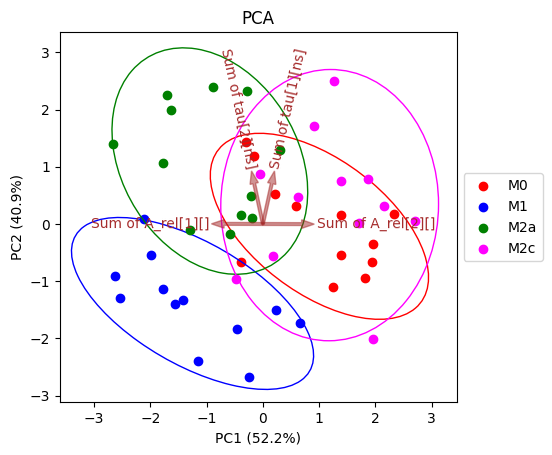

In [ ]:
# --- PCA --- #
pca = PCA(n_components=2) # Our data is small, so pca will do the classical eigen value decomposition
pca_embedding = pca.fit_transform(data)
ratio1 = pca.explained_variance_ratio_[0]*100
ratio2 = pca.explained_variance_ratio_[1]*100
print(pca.components_)

# --- Plot options --- #
plot_confidence_ellipse = True
confidence_ellipse_std = 2.0
center_axis = False
legend_outside = True
do_biplot = True
# --- Visualize--- #
fig, ax = plt.subplots()
plot_embeddings(ax, pca_embedding, labels, cdict, "PCA", "PC1 (%.3g%%)"%ratio1, "PC2 (%.3g%%)"%ratio2)
if do_biplot: plot_loadings(ax, pca.components_, df.columns.to_numpy()[1:])
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(48, 2)


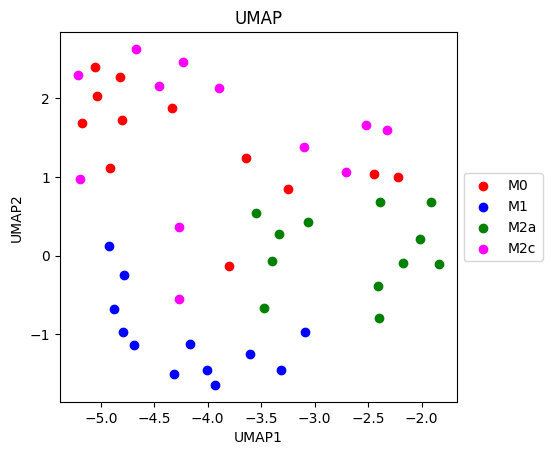

In [ ]:
# n_neighbors: Number of nearby points to use for learning the manifold structure. The higher the value, the more it focuses on global relationships.
# min_dist: Minimum distance for UMAP to pack the points. The lower the value, the more dense the clusters.
# See https://umap-learn.readthedocs.io/en/latest/parameters.html for details.
reducer = umap.UMAP(n_components=2, n_neighbors=25, min_dist=0.05, random_state=42)
umap_embedding = reducer.fit_transform(data)
print(umap_embedding.shape)

# --- Plot options --- #
# !!CAUTION!!
# For UMAP, confidence ellipse is not statistically meaningful,
# because unlike PCA, which is a linear dimensionality reduction method, UMAP is non-linear.
# In simple words, the distance between points in UMAP is not related to variance or global distance,
# so it cannot be interpreted statistically (at least not by confidence ellipses).
plot_confidence_ellipse = False
confidence_ellipse_std = 2.0
# !!CAUTION!!
# UMAP projections can be quite far from origin
center_axis = False
# --- Visualize--- #
fig, ax = plt.subplots()
plot_embeddings(ax, umap_embedding, labels, cdict, "UMAP", "UMAP1", "UMAP2")
plt.show()